In [1]:
import os, sys
import random

import pandas as pd
import numpy as np

import torch
from torch import nn

from tqdm.notebook import tqdm

from typing import NamedTuple, Dict, List, Tuple
from collections import defaultdict

from torch_scatter import scatter_std, scatter_mean, scatter_add
from MGCN import GCNMultiplex, CDTripletLoss

from utils import from_edges_to_tensor
from utils_graph import Network, read_net_from_txt, add_noise

from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (15, 10)

In [2]:
data_path_0 = "Data\\mLFR\\mlp0\\" 
data_path_2 = "Data\\mLFR\\mlp2\\" 
net_names = ["net_" + str(i) for i in range(50)]
mu = [i/len(net_names) for i in range(len(net_names))] # mixing parameter

manual_seed = 2023
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
def set_seed(seed, device):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if device == torch.device("cuda"):
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

### Check data

In [4]:
#check nets, names, and paths
for name in tqdm(net_names):
    
    network_0 = read_net_from_txt(data_path_0, name)
    network_2 = read_net_from_txt(data_path_2, name)
    
    network_edges_0 = list(map(lambda x: from_edges_to_tensor(x), network_0.network))
    network_edges_2 = list(map(lambda x: from_edges_to_tensor(x), network_2.network))
    
    communitie_tensor_0 = torch.tensor(list(network_0.communities.items())).T 
    communitie_tensor_0 = communitie_tensor_0 - torch.min(communitie_tensor_0, -1, keepdims=True)[0] 
    
    communitie_tensor_2 = torch.tensor(list(network_2.communities.items())).T 
    communitie_tensor_2 = communitie_tensor_2 - torch.min(communitie_tensor_2, -1, keepdims=True)[0] 
    
del network_0, network_2, network_edges_0, network_edges_2, communitie_tensor_0, communitie_tensor_2

  0%|          | 0/50 [00:00<?, ?it/s]

### MGCN-based Model

In [5]:
gcn1 = GCNMultiplex(
    in_features = 5,  
    out_features = 64,
    num_layers = 3, 
    activation = nn.ReLU(),
    dropout_prob = 0.6, 
    bias = True,
    add_self_loops = True,
    add_interlayer_loops = True
)

gcn1_res = GCNMultiplex(
    in_features = 64,  
    out_features = 64,
    num_layers = 3, 
    activation = nn.ReLU(), 
    dropout_prob = 0.6, 
    bias = True,
    add_self_loops = True,
    add_interlayer_loops = True
)

gcn2 = GCNMultiplex(
    in_features = 64,  
    out_features = 128,
    num_layers = 3, 
    activation = nn.ReLU(),
    dropout_prob = 0.4, 
    bias = True,
    add_self_loops = True,
    add_interlayer_loops = True
)

class Model(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.l1 = gcn1
        self.l1_res = gcn1_res
        self.l2 = gcn2
        
        
        self.act = nn.Tanh()
        self.act_finish = nn.Softmax(-1)
        
    def forward(self, x):
        nodes, edges = x
        out1 = self.act(self.l1((nodes, edges)))
        out1_res = self.act(self.l1_res((out1, edges))+out1)
        out2 = self.act(self.l2((out1_res, edges)))
        
        return out2
    
    def init_params(self):
        for child in self.children():
            if hasattr(child, "init_params"):
                child.init_params()
        
        
model = Model()     
model.to(device)

loss_fn = CDTripletLoss(p=2, std=0.5, alpha=1)
loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters())
print(f"Count of model parameters: {np.sum([np.prod(i.shape) for i in model.parameters()])}")

Count of model parameters: 112320


In [42]:
#train / test functions
def train(path, name, num_epoch=1000, device=device):
    
    network = read_net_from_txt(path, name)
    network_edges = list(map(lambda x: from_edges_to_tensor(x), network.network))
    communitie_tensor = torch.tensor(list(network.communities.items())).T 
    communitie_tensor = communitie_tensor - torch.min(communitie_tensor, -1, keepdims=True)[0] 
    nodes_representation = torch.randn((1, communitie_tensor.shape[-1], 5))

    data = (nodes_representation.to(device),  [n.to(device) for n in network_edges])
    gt = communitie_tensor.to(device)
    
    for epoch in range(num_epoch):
        out = model(data)
        optimizer.zero_grad()
        loss = loss_fn(out, gt)

        loss_val = loss[0] + loss[1] + loss[2] 

        loss_val.backward()
        optimizer.step()
        
@torch.no_grad()        
def evaluate(path, name, device=device):
    
    network = read_net_from_txt(path, name)
    network_edges = list(map(lambda x: from_edges_to_tensor(x), network.network))
    communitie_tensor = torch.tensor(list(network.communities.items())).T 
    communitie_tensor = communitie_tensor - torch.min(communitie_tensor, -1, keepdims=True)[0] 
    nodes_representation = torch.randn((1, communitie_tensor.shape[-1], 5))

    data = (nodes_representation.to(device),  [n.to(device) for n in network_edges])
    gt = communitie_tensor.to(device)
    
    out_train = model(data)

    comm_gt = communitie_tensor[1].numpy()
    kmeans = KMeans(n_clusters=len(np.unique(comm_gt)), max_iter=500, algorithm="elkan",  random_state=0).fit(out_train.detach().cpu().numpy().squeeze())
    comm_knn = kmeans.predict(out_train.detach().cpu().numpy().squeeze())
    nmi = normalized_mutual_info_score(comm_gt, comm_knn)
    
    return nmi

### Exp. I: Train model on each network and calculate train NMI

In [20]:
def train_evaluate(path, names, device=device):
    
    pd_result = pd.DataFrame()
    nmi_result = []
    
    for name in tqdm(names):
        
        set_seed(manual_seed, device)
        model.init_params()
        
        train(path, name, num_epoch=1000, device=device)
        nmi = evaluate(path, name, device=device)
        
        nmi_result.append(nmi)
        torch.cuda.empty_cache()
        
    pd_result["net"] = names
    pd_result["nmi"] = nmi_result
    
    return pd_result
    

In [8]:
#nets with 0-interlayer swap chance
result_0 = train_evaluate(data_path_0, net_names)
#result_0.to_csv(r"./results/result_0.csv", index=False)
result_0_linear = pd.read_csv(r"./results/result_0_linear.csv")


  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
#nets with 0.2-interlayer swap chance
result_2 = train_evaluate(data_path_2, net_names)
#result_2.to_csv(r"./results/result_2.csv", index=False)
result_2_linear = pd.read_csv(r"./results/result_02_linear.csv")

  0%|          | 0/50 [00:00<?, ?it/s]

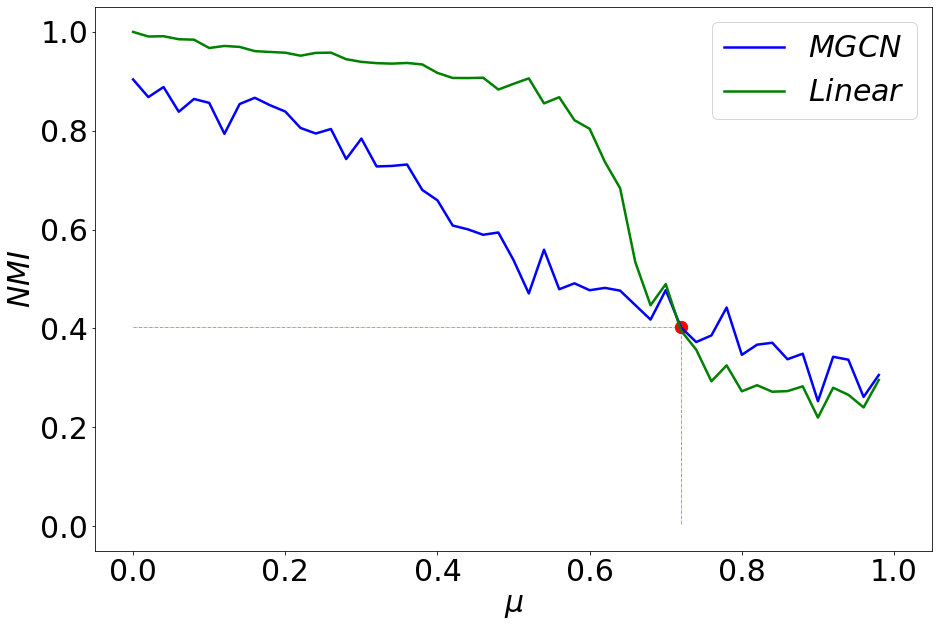

In [89]:
ax1 = plt.subplot()
threshold_idx = np.argmax(np.asarray(result_0.nmi) - np.asarray(result_0_linear.nmi_max) >= 0)
threshold_mu = mu[threshold_idx]
threshold_nmi = np.asarray(result_0.nmi)[threshold_idx]

ax1.plot(mu, result_0.nmi, color='blue', linewidth= 2.5, label=r"${MGCN}$")
ax1.plot(mu, result_0_linear.nmi_max, color='green', linewidth= 2.5, label=r"${Linear}$")

ax1.plot(mu[:threshold_idx+1], [threshold_nmi for i in range(threshold_idx+1)], color="red", linewidth= .5, linestyle='dashdot')
ax1.axvline(threshold_mu, ymin = 0.05, ymax = threshold_nmi, color = 'red', linewidth= .5, linestyle='dashdot')
ax1.scatter(threshold_mu, threshold_nmi, color = 'red', s=150)

ax1.legend(loc='upper right', prop={'size': 30})
ax1.set_xlim(-0.05, 1.05)
ax1.set_ylim(-0.05, 1.05)
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xlabel(r'$\mu$', fontsize=30)
ax1.set_ylabel(r'$NMI$', fontsize=30)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)

#plt.savefig('./results/NMI_0.png', dpi=300)

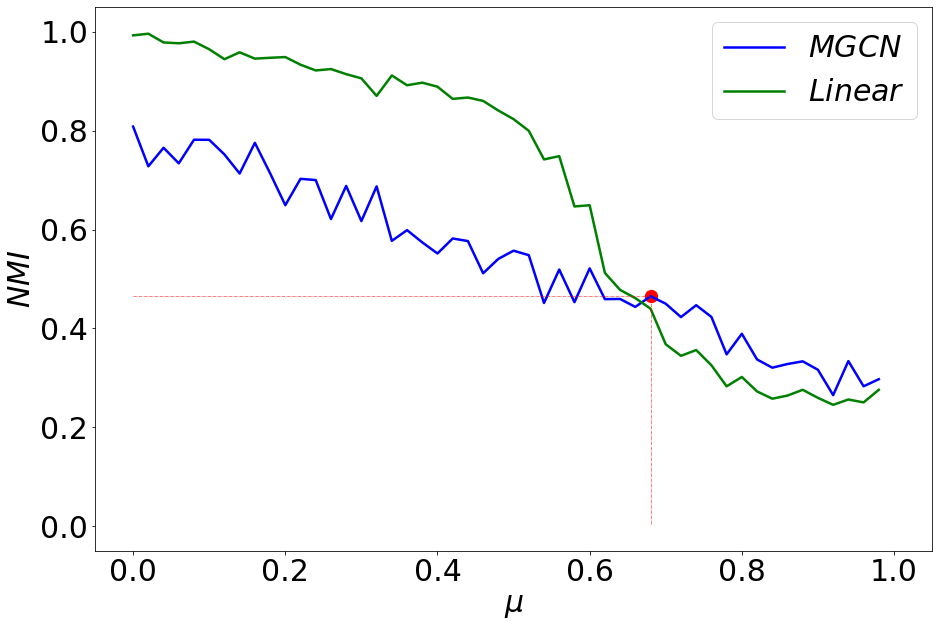

In [90]:
ax1 = plt.subplot()
threshold_idx = np.argmax(np.asarray(result_2.nmi) - np.asarray(result_2_linear.nmi_max) >= 0)
threshold_mu = mu[threshold_idx]
threshold_nmi = np.asarray(result_2.nmi)[threshold_idx]

ax1.plot(mu, result_2.nmi, color='blue', linewidth= 2.5, label=r"${MGCN}$")
ax1.plot(mu, result_2_linear.nmi_max, color='green', linewidth= 2.5, label=r"${Linear}$")

ax1.plot(mu[:threshold_idx+1], [threshold_nmi for i in range(threshold_idx+1)], color="red", linewidth= .5, linestyle='dashdot')
ax1.axvline(threshold_mu, ymin = 0.05, ymax = threshold_nmi, color = 'red', linewidth= .5, linestyle='dashdot')
ax1.scatter(threshold_mu, threshold_nmi, color = 'red', s=150)

ax1.legend(loc='upper right', prop={'size': 30})
ax1.set_xlim(-0.05, 1.05)
ax1.set_ylim(-0.05, 1.05)
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xlabel(r'$\mu$', fontsize=30)
ax1.set_ylabel(r'$NMI$', fontsize=30)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)

#plt.savefig('./results/NMI_2.png', dpi=300)

### Exp. II: Train model on one network and calculate test NMI on another networks

In [128]:
def train_test(path, names, device=device):
    
    pd_result = pd.DataFrame()
    names_train = []
    names_test = []
    nmi_result = []
    
    for name_train in tqdm(names):
        
        set_seed(manual_seed, device)
        model.init_params()
        
        train(path, name_train, num_epoch=1000, device=device)
        
        for name_test in tqdm(names):
            
            nmi = evaluate(path, name_test, device=device)
            
            nmi_result.append(nmi)
            names_train.append(name_train)
            names_test.append(name_test)
            
        torch.cuda.empty_cache()
        
    pd_result["net_train"] = names_train
    pd_result["net_test"] = names_test
    pd_result["nmi"] = nmi_result
    
    return pd_result

In [129]:
test_0 = train_test(data_path_0, net_names[::10])
#test_0.to_csv(r"./results/test_0.csv", index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [137]:
test_2 = train_test(data_path_2, net_names[::10])
#test_2.to_csv(r"./results/test_2.csv", index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [149]:
test_0_pivot = test_0.pivot(index="net_test", columns="net_train", values="nmi")
test_0_pivot.style.highlight_max(color = 'lightgreen', axis = 1)

net_train,net_0,net_10,net_20,net_30,net_40
net_test,,,,,
net_0,0.874111,0.857649,0.852505,0.797820,0.689794
net_10,0.787292,0.825127,0.816154,0.779778,0.679086
net_20,0.658371,0.647969,0.651325,0.670989,0.524562
net_30,0.449551,0.447728,0.487714,0.521333,0.440530
net_40,0.373296,0.356098,0.381809,0.396272,0.361370


In [150]:
test_2_pivot = test_2.pivot(index="net_test", columns="net_train", values="nmi")
test_2_pivot.style.highlight_max(color = 'lightgreen', axis = 1)

net_train,net_0,net_10,net_20,net_30,net_40
net_test,,,,,
net_0,0.757880,0.785520,0.789281,0.781627,0.573248
net_10,0.666372,0.653949,0.653742,0.654690,0.484123
net_20,0.549265,0.547341,0.537926,0.545541,0.430018
net_30,0.511942,0.500484,0.535942,0.513264,0.393330
net_40,0.437120,0.425461,0.441913,0.450130,0.378830
